<a href="https://colab.research.google.com/github/ahmedabdelhameed/PyTorch/blob/master/MLP_MINIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import PIL.ImageOps
import requests
from PIL import Image

In [56]:
# Hyperparameters
input_size = 784
hidden_layer1_size =300
hidden_layer2_size =100
num_classes = 10
batch_size = 100
num_epochs = 3
learning_rate = 0.01

In [57]:
# Create Fully Connected Network
class Model(nn.Module):
    def __init__(self, input_size, h1, h2, output_size):
        super(Model,self).__init__() 
        self.fc_1 = nn.Linear(input_size, h1)
        self.fc_2 = nn.Linear(h1, h2)
        self.fc_3 = nn.Linear(h2, output_size)
    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [58]:
# For testing the model output shape
model = Model(784, 300, 100, 10)
x = torch.randn(64,784)
print(model(x).shape)

torch.Size([64, 10])


In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
# Loading the dataset
transform  = transforms.Compose([transforms.Resize((28,28)),
                                 transforms.ToTensor()
                                ])
training_dataset = datasets.MNIST(root='./mnist', train=True, 
                                  download=True, transform= transform)
validation_dataset = datasets.MNIST(root='./mnist', train=False, 
                                  download=True, transform= transform) 

print ("length of training_dataset: ", len(training_dataset))
print ("length of validation_dataset: ", len(validation_dataset))

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!
length of training_dataset:  60000
length of validation_dataset:  10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([1, 28, 28])
0


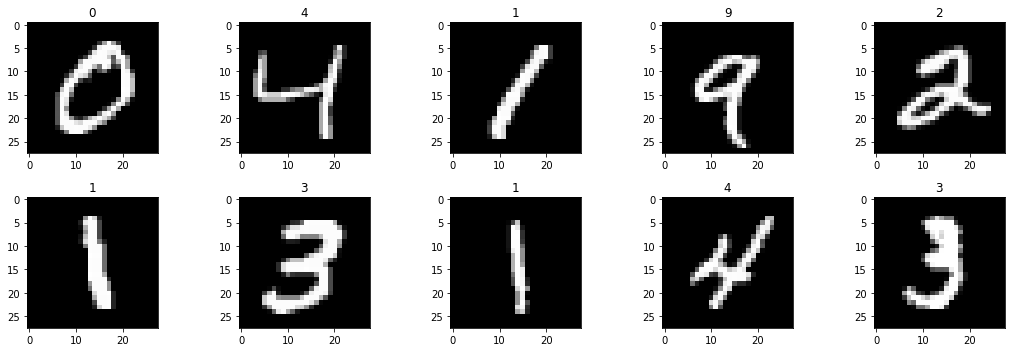

In [60]:
print(training_dataset[1][0].shape)
print(training_dataset[1][1])

# Drawing the first 10 digits with labels starting at index 1
fig=plt.figure(figsize=(15, 5))

for idx in range(1, 11):
  fig.add_subplot(2, 5, idx)
  # title is the image's label
  plt.title(training_dataset[idx][1])
  plt.imshow(transforms.ToPILImage()(training_dataset[idx][0]), cmap='gray')
plt.tight_layout()
plt.show()

In [61]:
training_loader = DataLoader(dataset=training_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)
  
# We don't need to shuffle validation data 
validation_loader = DataLoader(dataset=validation_dataset, 
                                              batch_size=batch_size,
                                              shuffle=False)

In [62]:
print(len(training_loader.dataset))

60000


In [63]:
print(len(validation_loader.dataset))

10000


In [64]:
# Network Initialization
model = Model(input_size, hidden_layer1_size, hidden_layer2_size, num_classes).to(device)
print (model)

Model(
  (fc_1): Linear(in_features=784, out_features=300, bias=True)
  (fc_2): Linear(in_features=300, out_features=100, bias=True)
  (fc_3): Linear(in_features=100, out_features=10, bias=True)
)


In [65]:
# Cross Entropy Loss with Adam Optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


for e in range(num_epochs):

    train_corrects = 0.0 
    train_batch_loss = 0.0
    train_epoch_loss = 0.0
    val_corrects = 0.0
    val_epoch_loss = 0.0
    
    # loop through 60000 samples 100 at a time
    for batch_idx, data in enumerate(training_loader, start=1):
        # data[0] is the array containing 100(batch_size) number of 1*28*28
        # data[1] is the array containing 100 number of lables
        # print("\nBatch = " + str(batch_idx))
        # print(data[0].shape)
        # convert (100, 1, 28 , 28) to (100, 748)
        inputs = data[0].view(data[0].shape[0], -1)
        labels = data[1]

        inputs = inputs.to(device= device)
        labels = labels.to(device= device)

        #forward 
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print(outputs.shape)  # (batch_size,10)
        # Return the index of the highest possibility
        # which are the predicted labels
        _, preds = torch.max(outputs, 1)

        train_batch_loss += loss.item()

        # sum up all the correct prediction
        # since (preds==labels).sum() is a tensor
        # we use item() to extract the number
        train_corrects += (preds == labels).sum().item()

        # print training loss every 100 mini-batch
        # train_batch_loss is the average loss for 100 mini-batch
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.2f}%)] Loss: {:.6f}'.format(
                   e + 1 , 
                   batch_idx * len(data[0]), 
                   len(training_loader.dataset),
                   100.* batch_idx * len(data[0]) / len(training_loader.dataset), 
                   train_batch_loss / 100 ))
            # accumulate loss for the epoch
            print(train_batch_loss)
            train_epoch_loss += train_batch_loss
            # reset the loss for every mini-batch
            train_batch_loss = 0.0
    else:
        # torch.no_grad deactivate the auograd engine, 
        # reduce memory usage and speed up computations
        # model.eval()
        with torch.no_grad():
            
            for val_data in validation_loader:
                val_inputs = val_data[0].view(val_data[0].shape[0], -1)
                val_labels = val_data[1]

                val_inputs = val_inputs.to(device = device)
                val_labels = val_labels.to(device = device)
                
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_epoch_loss += val_loss.item()
                val_corrects += (val_preds == val_labels).sum().item()


        # print result for every epoch 
        train_accuracy = 100. * train_corrects / len(training_loader.dataset)
        # here batch_idx is the total number of mini-batch = 600
        train_epoch_loss /= batch_idx

        print('epoch :', (e+1))
        print('Train set: Accuracy: {}/{} ({:.2f}%), Average Loss: {:.6f}'.format(
                train_corrects, len(training_loader.dataset),
                train_accuracy, train_epoch_loss))


        
        val_accuracy = 100. * val_corrects / len(validation_loader.dataset)
        val_epoch_loss /= batch_idx

        print('Validation set: Accuracy: {}/{} ({:.2f}%), Average Loss: {:.6f}'.format(
                val_corrects, len(validation_loader.dataset),
                val_accuracy, val_epoch_loss))
        print('*******************************************************************')
        # model.train()

Train Epoch: 1 [10000/60000 (16.67%)] Loss: 0.478278
47.82784530520439
Train Epoch: 1 [20000/60000 (33.33%)] Loss: 0.205496
20.549591943621635
Train Epoch: 1 [30000/60000 (50.00%)] Loss: 0.211165
21.116484373807907
Train Epoch: 1 [40000/60000 (66.67%)] Loss: 0.174382
17.43823290616274
Train Epoch: 1 [50000/60000 (83.33%)] Loss: 0.152220
15.22204990312457
Train Epoch: 1 [60000/60000 (100.00%)] Loss: 0.162075
16.20749913342297
epoch : 1
Train set: Accuracy: 55829.0/60000 (93.05%), Average Loss: 0.230603
Validation set: Accuracy: 9600.0/10000 (96.00%), Average Loss: 0.022665
*******************************************************************
Train Epoch: 2 [10000/60000 (16.67%)] Loss: 0.129751
12.975102873519063
Train Epoch: 2 [20000/60000 (33.33%)] Loss: 0.122274
12.22742222622037
Train Epoch: 2 [30000/60000 (50.00%)] Loss: 0.128054
12.805449006147683
Train Epoch: 2 [40000/60000 (66.67%)] Loss: 0.134411
13.441104024648666
Train Epoch: 2 [50000/60000 (83.33%)] Loss: 0.109348
10.9347746972